# ДЗ 5

* Необходимо скачать и подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples/notebooks для обучения модели на сегментацию губ (обратите внимание, что сегментация подразумевает уже два класса: фон и губы).
* И затем обучить Модель на выбор из segmentation_models_pytorch
* (Усложненное задание) Переделайте архитектуру декодера Unet так, как в этой работе https://www.ics.uci.edu/~haoyum3/papers/slides_icivc.pdf. Эта тема пересекается с темой о второго вебинара о LSTM-сетях. И попробуйте обучить получившуюся нейронную сеть.

## Извините, заглушка, планирую закончить до конца дня 25.02

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm.notebook import tqdm


In [2]:
# https://github.com/matplotlib/matplotlib/issues/21513
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
from PIL import Image
from functools import lru_cache

image_size=128

class Dataset(torch.utils.data.Dataset):

    def __init__(self, data_path):
        self.data_path = data_path
        df_list = pd.read_csv(data_path + '/list.csv')
        image_paths = (self.data_path + '/720p/' + fn for fn in df_list['filename'])
        label_paths = (self.data_path + '/mask/' + fn for fn in df_list['mask'])
        paths=list(filter(lambda f: os.path.isfile(f[0]) and os.path.isfile(f[1]), zip(image_paths, label_paths)))
        self.items = []
        for path in tqdm(paths): # подготовим сразу в конструкторе
            try:
                img = Image.open(path[0]).resize((image_size, image_size))
                img = np.asarray(img).astype('float')
                img = torch.as_tensor(img)/255    
                img = img.permute(2,0,1)

                lab = np.asarray(Image.open(path[1]).resize((image_size, image_size)))[:,:,1]/255
                lab = torch.as_tensor(lab)
                self.items.append((img.float(), lab.float()))
            except Exception as ex:
                print(f"Ошибка загрузки {path[0]} или {path[1]}", str(ex))
                
    def __getitem__(self, index):
        return self.items[index]

    def __len__(self):
        return len(self.items)

In [4]:
ds = Dataset('data/set-lipstick-original-for-segmentation')

  0%|          | 0/28540 [00:00<?, ?it/s]

Ошибка загрузки data/set-lipstick-original-for-segmentation/720p/image00000616.jpg или data/set-lipstick-original-for-segmentation/mask/mask00000616.png too many indices for array: array is 2-dimensional, but 3 were indexed


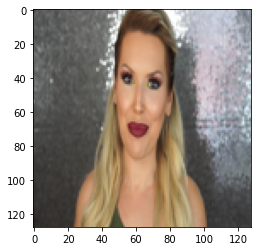

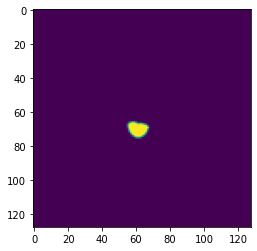

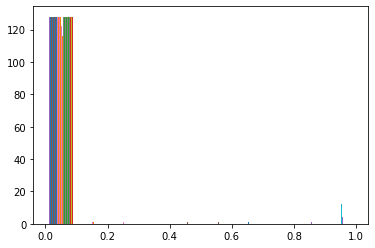

In [5]:
img, mask = ds[2]
plt.imshow(img.permute(1,2,0))
plt.show()
plt.imshow(mask)
plt.show()
plt.hist(mask)
plt.show()


In [6]:
import segmentation_models_pytorch as smp

In [77]:
def dice_loss(pred, target):
    eps = 0.0001
    numerator = 2 * torch.sum(pred * target)
    denominator = torch.sum(pred) + torch.sum(target)
    return 1. - numerator / (denominator + eps)

print(dice_loss(mask, torch.zeros(mask.shape)))
print(dice_loss(mask, torch.ones(mask.shape)))
print(dice_loss(mask, mask))

tensor(1.)
tensor(0.9898)
tensor(0.0801)


In [81]:
def evaluate(net, ds):
    dl = torch.utils.data.DataLoader(ds, batch_size=1, shuffle=False)
    loss_fn = smp.utils.losses.DiceLoss()
    net.eval()
    total_loss = 0
    count = 0
    for X, y in tqdm(dl):
        count += len(y)
        preds = net.predict(X)
        loss = float(loss_fn(preds, y))
        if loss < 0:
            raise Exception("Отрицательный dice-loss")
        total_loss += loss
    return total_loss/count


def train_and_test(net, ds_train, ds_val, optimizer_class=torch.optim.Adam, n_epochs=10, lr=0.01, report_on=-1, batch_size=256):
    
    print('========================================================')
   
    params = [ p for p in net.parameters() if p.requires_grad]
    print('Число обучаемых параметров', len(params))
    optimizer = optimizer_class(params, lr=0.01)
    print(' Оптимизатор: ', optimizer)

    def print_results():
        for title, ds in [
#                ('Тренировочный', ds_train), # слишком долго для resnet 
                ('Валидационный', ds_val)
            ]:
            r = evaluate(net, ds)
            print(f"    {title} набор: dice-loss: {r:.2f}%")
        return r
    
    print(' До обучения:')
    print_results()
    
    dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size)
    criterion = smp.utils.losses.DiceLoss()

    net.train()
    report_on = max(len(dl_train) if report_on == -1 else report_on, 1)
    for epoch in range(n_epochs):
        print('--------- Эпоха ', epoch, '/', n_epochs, ' ------------------')
        running_loss = 0.0
        for i, data in enumerate(tqdm(dl_train)):
            inputs, labels = data[0], data[1]

            # обнуляем градиент
            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # выводим статистику о процессе обучения
            running_loss += loss.item()
            if (i+1) % report_on == 0:    # печатаем каждые report_on mini-batches
                print('Выучено батчей : %5d; loss: %.3f' % (i + 1, running_loss / report_on))
                running_loss = 0.0
                
    print(' Обучение закончено!')
    print(' После обучения:')
    return print_results()


In [82]:
from sklearn.model_selection import train_test_split 
ds_train, ds_val = train_test_split(ds, test_size=0.05, random_state=7)
print(len(ds_train))
print(len(ds_val))

27112
1427


In [83]:
net = smp.FPN('resnet34', encoder_weights='imagenet', classes=1, activation='sigmoid')

In [ ]:
train_and_test(net, ds_train, ds_val)

Число обучаемых параметров 139
 Оптимизатор:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)
 До обучения:


  0%|          | 0/1427 [00:00<?, ?it/s]

    Валидационный набор: dice-loss: 0.99%
--------- Эпоха  0 / 10  ------------------


  0%|          | 0/106 [00:00<?, ?it/s]

Выучено батчей :   106; loss: 0.912
--------- Эпоха  1 / 10  ------------------


  0%|          | 0/106 [00:00<?, ?it/s]

Выучено батчей :   106; loss: 1.000
--------- Эпоха  2 / 10  ------------------


  0%|          | 0/106 [00:00<?, ?it/s]

Выучено батчей :   106; loss: 1.000
--------- Эпоха  3 / 10  ------------------


  0%|          | 0/106 [00:00<?, ?it/s]

Выучено батчей :   106; loss: 1.000
--------- Эпоха  4 / 10  ------------------


  0%|          | 0/106 [00:00<?, ?it/s]

Выучено батчей :   106; loss: 1.000
--------- Эпоха  5 / 10  ------------------


  0%|          | 0/106 [00:00<?, ?it/s]